This notebook is an example of calculating Emrpirical Risk Bounds on a real dataset.
The dataset was sourced from here: https://www.kaggle.com/primaryobjects/voicegender

### Step 1: imports and loading data

In [1]:
# import sltlib module from parallel folder

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sltlib import rademacher, outlier
from sltlib.utils import *
from sltlib.basefuncs import *

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Plotting lib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def data_prep(data):
    data_size = len(data.index)

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    y = np.array(gender_encoder.fit_transform(y))
    y = y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(X)
    X = np.array(scaler.transform(X))

    return X, y

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split
voice_shuffle = load_file('voice_shuffled')

In [5]:
voice_shuffle.shape

(3168, 21)

In [6]:
X_full, y_full = data_prep(voice_shuffle)

# Cut down to 10 features
X_full = X_full[:,:10]

# Add intercept as a feature
X_extended = np.ones((X_full.shape[0],X_full.shape[1] + 1))
X_extended[:,:-1] = X_full

# Use 100 points for training
X, X_test, y, y_test = train_test_split(X_extended, y_full, train_size=100, random_state=45)

In [7]:
X.shape

(100, 11)

### step 2: get normal SVM models

In [8]:
mname = "voice_models"

In [26]:
# generate models

C_vals = np.logspace(-2, 4, 15)
models = list()

for index, cval in enumerate(C_vals):
    print(index,end='/')
    models.append(svm.LinearSVC(loss='hinge', dual=True, C=cval, fit_intercept=False, random_state=42, max_iter=1e7))
    models[index].fit(X, y)

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/

In [27]:
save_file(mname,models)

In [9]:
# Load models from file
C_vals = np.logspace(-2, 4, 15)
models = load_file(mname)

In [10]:
msizes=[]
bounds=[]
risks=[]
emp_risks=[]
for model in models:
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    
    C = model.get_params()['C']
    emp_risk = (y != model.predict(X)).sum()/X.shape[0]
    risk = (y_test != model.predict(X_test)).sum()/X_test.shape[0]
    
    risks.append(risk)
    emp_risks.append(emp_risk)
    
    print(C, margin_size, model.intercept_, emp_risk, risk, sep='\t')
    msizes.append(margin_size)
    bounds.append(np.abs(model.intercept_))

0.01	2.054689309843012	0.0	0.24	0.27477183833116037
0.02682695795279726	1.1521239229836053	0.0	0.14	0.1636245110821382
0.07196856730011521	0.7429971832735864	0.0	0.13	0.1424380704041721
0.19306977288832497	0.5085355423085413	0.0	0.12	0.12972620599739243
0.517947467923121	0.39593881417341376	0.0	0.08	0.1059322033898305
1.3894954943731375	0.3185774926273573	0.0	0.07	0.09941329856584094
3.727593720314938	0.27384738537082287	0.0	0.07	0.09810951760104303
10.0	0.24026233737443922	0.0	0.08	0.09941329856584094
26.826957952797247	0.1990602101436239	0.0	0.08	0.10039113428943937
71.96856730011514	0.14349622966023895	0.0	0.08	0.10104302477183832
193.06977288832496	0.13100894839995675	0.0	0.09	0.10332464146023468
517.9474679231213	0.08412669803568178	0.0	0.09	0.10658409387222946
1389.4954943731361	0.08403933100531108	0.0	0.09	0.10658409387222946
3727.593720314938	0.08403721382454483	0.0	0.09	0.10658409387222946
10000.0	0.08228188103090901	0.0	0.1	0.10528031290743155


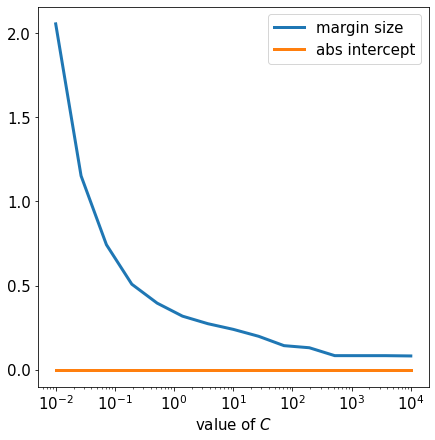

In [11]:
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, msizes, label="margin size", lw=3)
plt.plot(C_vals, bounds, label="abs intercept", lw=3)
plt.legend()

plt.show()

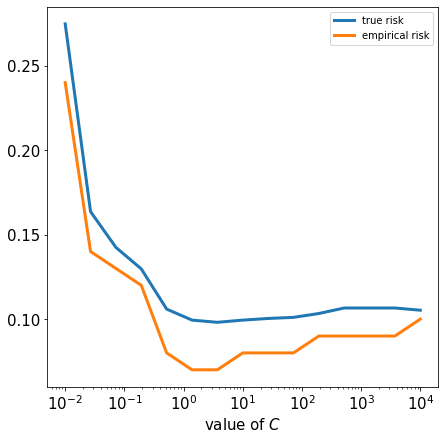

In [12]:
plt.figure(figsize=(7,7))
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, risks, label="true risk", lw=3)
plt.plot(C_vals, emp_risks, label="empirical risk", lw=3)
plt.legend(fontsize=10)

### step 3: calc rademacher complexities and outlier function

In [13]:
# We will be saving our progress in histories/voice

folder_name = "voice"

In [14]:
runs_per_sample = 1
maxiter = 200
init_temp = 5500
accept = -5

pump_cycles = 1000

m = X.shape[0]

In [15]:
Mlc = rademacher.LML(X=X_extended,
          Y=y_full,
          path=None,    # set path manually later
          margin=None,  # set margin manually later
          sample_size = m,
          solver_args={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept},
          balanced=True)

Lin = rademacher.Linear(X=X_extended, Y=y_full,
            path=None,    # set path manually later
            sample_size = m,
            balanced=True)

Out = outlier.LML(X=X_extended, Y=y_full,
                path=None,    # set path manually later
                margin=None,  # set margin manually later
                solver_args={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept},
                sample_size = m)


The following block of code will sample each of the three constants *pump_cycles* number of times. All progress is saved, so its ok to interrupt and relaunch this block. If no history cache is present, it will write "Failed to load history" and create new cache files in histories/voice/.

In [34]:
for pc in range(pump_cycles):

    for index, model in enumerate(models):
        
        print('\n', index, ':', pc, '///', end=' ')
        
        # get margin size
        
        w = np.array(model.coef_[0])
        mar = 1 / np.sqrt(np.sum(w ** 2))
        
        # sample X and Y sets of size m from the whole set
        Mlc._sample_set()
        Pump_X = Mlc.X
        Pump_Y = Mlc.Y

        radvecRR = Mlc._gen_radvec()
        
        #################
        ## Calculate Confidence Rademacher Complexity        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rconfidence_NEW'
        
        Lin.path = DATA_SAVE_NAME
        Lin.radvec = radvecRR
        Lin.X = Pump_X
        Lin.Y = Pump_Y
        
        Lin.load()
        Lin.calc(verbose=True, resample=False)
        Lin.save()

        #################
        ## Calculate Margin loss Rademacher Complexity        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW'
        
        Mlc.path = DATA_SAVE_NAME
        Mlc.margin = mar
        Mlc.radvec = radvecRR
        Mlc.X = Pump_X
        Mlc.Y = Pump_Y
        
        Mlc.load()
        Mlc.calc(radvec=radvecRR, verbose=True, resample=False)
        Mlc.save()

        #################
        ## Calculate Outlier Func
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Outlier_NEW'
        
        Out.path = DATA_SAVE_NAME
        Out.margin = mar
        Out.X = Pump_X
        Out.Y = Pump_Y
        
        Out.load()
        Out.calc(verbose=True, resample=False)
        Out.save()
 


 0 : 0 /// LIN::7.160608094983263
LML::4.55342307191544
LML::0.09242940926922089

 1 : 0 /// LIN::6.3879699401491745
LML::4.198178174950882
LML::0.052210934687123345

 2 : 0 /// LIN::7.8455195854919015
LML::6.552010899264988
LML::0.10242895456066264

 3 : 0 /// LIN::17.44341261370662
LML::9.63667311573535
LML::0.1449139816562356

 4 : 0 /// LIN::5.497980337539674
LML::6.732848078883633
LML::0.07204764867645563

 5 : 0 /// LIN::4.447060368055522
LML::10.160328497776987
LML::0.11790815970360047

 6 : 0 /// LIN::18.572873735532983
LML::9.982930914529833
LML::0.1109483182587701

 7 : 0 /// LIN::14.940372009351535
LML::8.546937170972324
LML::0.09895062822440748

 8 : 0 /// LIN::3.354543286689659
LML::14.432539089659869
LML::0.10725581384435323

 9 : 0 /// LIN::13.956914309807589
LML::9.537489266362899
LML::0.19341323334822585

 10 : 0 /// LIN::8.035263799706602
LML::15.149639899774094
LML::0.13270826191883667

 11 : 0 /// LIN::6.868534557549279
LML::12.762506786355047
LML::0.13914206412093

KeyboardInterrupt: 

### step 4: aggregate constants

In [35]:
confs = [] #
rads = [] # 
outliers = [] #
true_risks = [] #
emp_mloss = [] #
true_mloss = [] #
margins = []
emp_risks = []
true_risks = []
for index, model in enumerate(models):
    confs.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rconfidence_NEW')))
    rads.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW')))
    outliers.append(np.mean(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier_NEW')))

    true_risks.append( (y_test != model.predict(X_test)).sum()/X_test.shape[0] )
    emp_risks.append( (y != model.predict(X)).sum()/X.shape[0] )
    
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    b = 0 # model.intercept_
    
    emp_mloss.append( np.mean(margin_loss(X, y, w, margin_size, )) )
    true_mloss.append( np.mean(margin_loss(X_test, y_test, w, margin_size)) )
    margins.append(margin_size)
    

In [36]:
print(len(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW')['rademacher']))

39


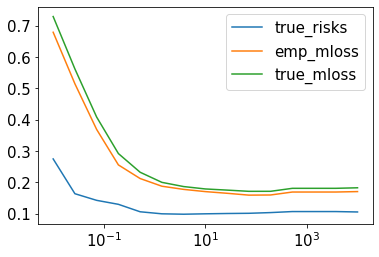

In [37]:
plt.plot(C_vals,true_risks, label='true_risks')
plt.plot(C_vals,emp_mloss, label='emp_mloss')
plt.plot(C_vals,true_mloss, label='true_mloss')

plt.xscale('log')
plt.legend()

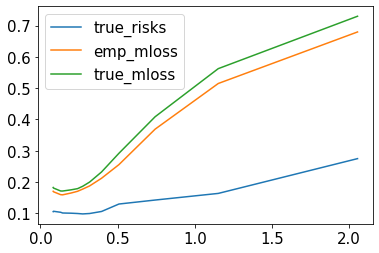

In [38]:
plt.plot(margins,true_risks, label='true_risks')
plt.plot(margins,emp_mloss, label='emp_mloss')
plt.plot(margins,true_mloss, label='true_mloss')

plt.legend()

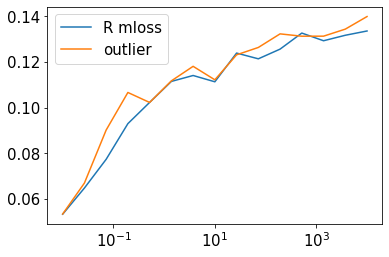

In [39]:
plt.plot(C_vals,rads, label='R mloss')
plt.plot(C_vals,outliers, label='outlier')

plt.xscale('log')
plt.legend()

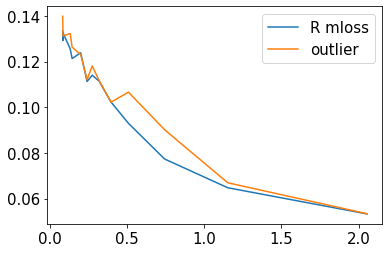

In [40]:
plt.plot(margins,rads, label='R mloss')
plt.plot(margins,outliers, label='outlier')

plt.legend()

### step 5: aggregate formulas

(1) True risk <

(2) true_mloss <

(3) emp_risk + outlier + sqrt(log(1/delta)/2m) <

(4) emp_risk + 2 * rad_mloss + sqrt(log(1/delta)/2m) <

(5) emp_risk + 2/rho * conf + sqrt(log(1/delta)/2m)

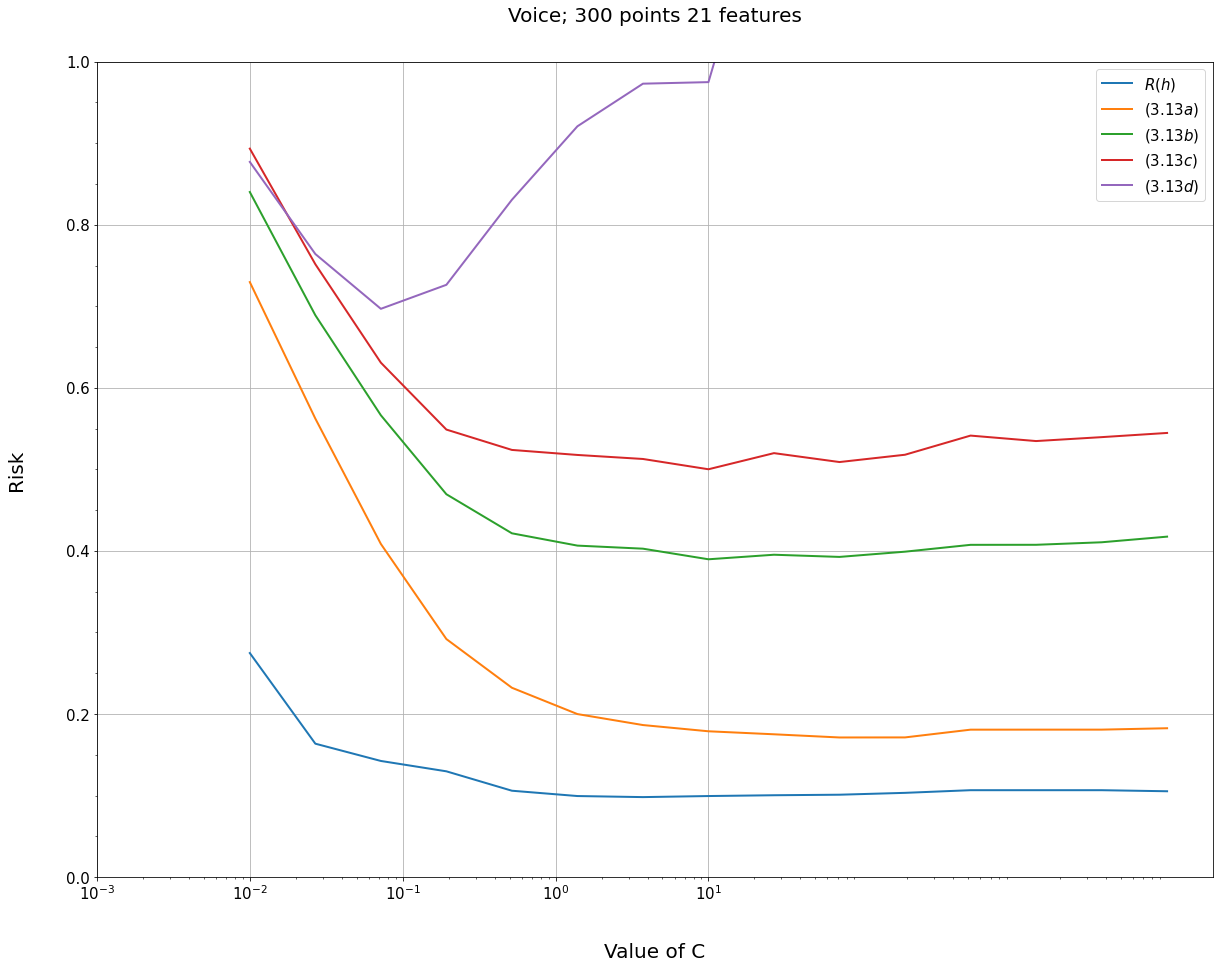

In [41]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$(3.13a)$')
plt.plot(C_vals, f3, lw=2, label=r'$(3.13b)$')
plt.plot(C_vals, f4, lw=2, label=r'$(3.13c)$')
plt.plot(C_vals, f5, lw=2, label=r'$(3.13d)$')


plt.ylim(0,1)
plt.xscale('log')

ax.minorticks_on()
ax.grid(True, which='major')

ax.xaxis.set_major_locator(MultipleLocator(0.5))

plt.xticks([1e-3, 1e-2, 1e-1, 1e-0, 10], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Value of C", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
plt.title(r'Voice; 300 points 21 features', fontsize=20, pad=40)

plt.savefig("images/VoiceC.png", bbox_inches='tight')

plt.show()


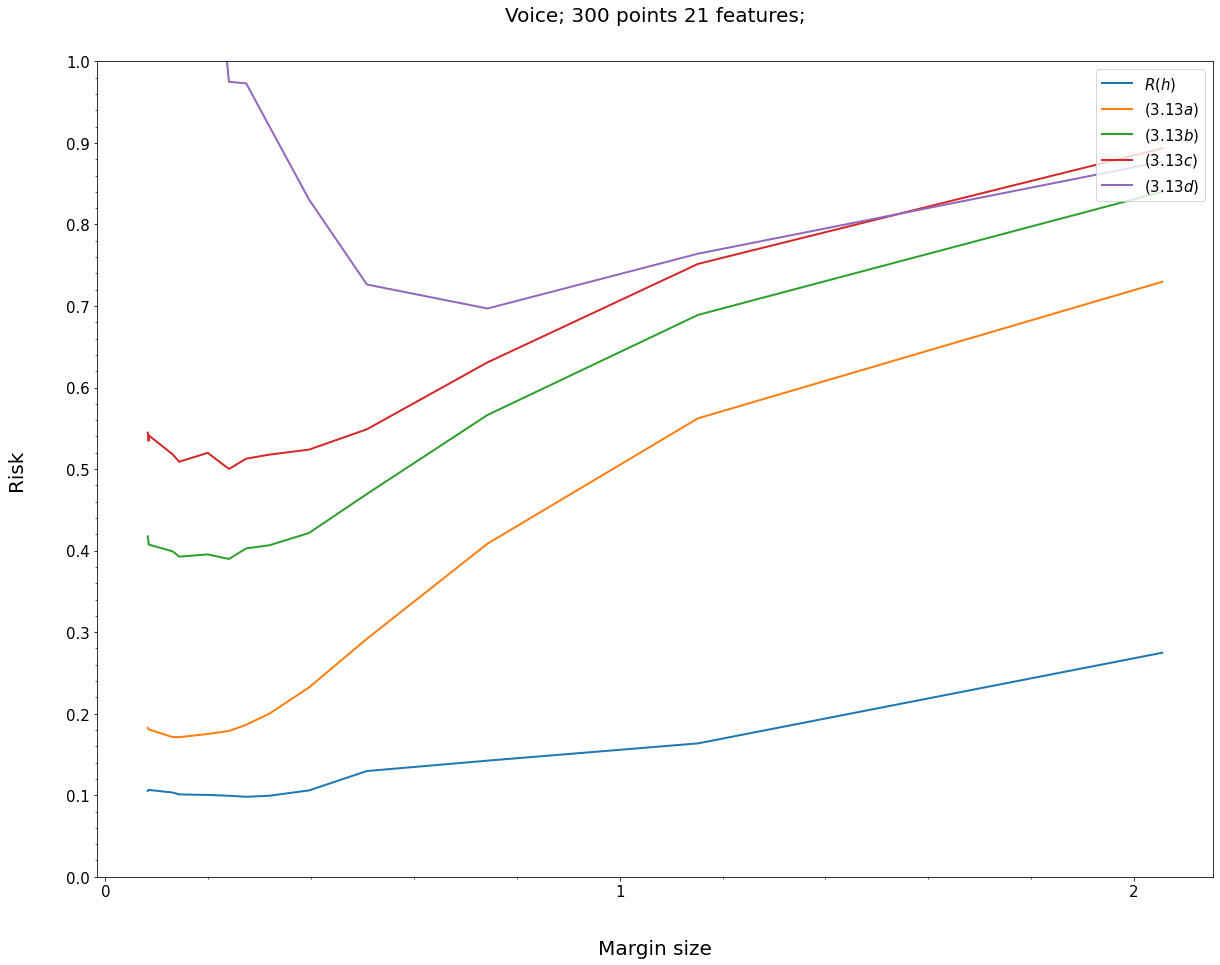

In [42]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$(3.13a)$')
plt.plot(margins, f3, lw=2, label=r'$(3.13b)$')
plt.plot(margins, f4, lw=2, label=r'$(3.13c)$')
plt.plot(margins, f5, lw=2, label=r'$(3.13d)$')

plt.ylim(0,1)

ax.minorticks_on()
ax.grid(True, which='major')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.grid(which='major', color='#CCCCCC', linestyle='--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
plt.title(r'Voice; 300 points 21 features;', fontsize=20, pad=40)

plt.savefig("images/VoiceM", bbox_inches='tight')

plt.show()
